In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
sns.set()
sns.set(rc={'figure.figsize':(11, 4)})


## Load data

In [2]:
samples = pd.read_csv("dataset_mood_smartphone.csv", 
                      sep=',', 
                      index_col=0, 
                      parse_dates=["time"],
                      dtype={"id": "category", "variable": "category"})
samples = samples.rename(columns={"time": "datetime"})
samples

,id,datetime,variable,value
1,AS14.01,2014-02-26 13:00:00.000,mood,6.000
2,AS14.01,2014-02-26 15:00:00.000,mood,6.000
3,AS14.01,2014-02-26 18:00:00.000,mood,6.000
4,AS14.01,2014-02-26 21:00:00.000,mood,7.000
5,AS14.01,2014-02-27 09:00:00.000,mood,6.000
...,...,...,...,...
2770399,AS14.30,2014-04-11 07:51:16.948,appCat.weather,8.032
2772465,AS14.30,2014-04-19 11:00:32.747,appCat.weather,3.008
2774026,AS14.30,2014-04-26 10:19:07.434,appCat.weather,7.026
2774133,AS14.30,2014-04-27 00:44:48.450,appCat.weather,23.033


## Remove duplicates

In [4]:
dupes = samples.duplicated(subset=['datetime', 'variable', 'id'], keep='last')
samples_deduped = samples[dupes == False]

## Remove negative values for appCat.* variables

In [5]:
samples_cleaned = samples_deduped[(~(samples_deduped['variable'].str.startswith('app'))) |
                                   ((samples_deduped['variable'].str.startswith('app')) & 
                                   (samples_deduped['value'] > 0))]
samples_cleaned

,id,datetime,variable,value
1,AS14.01,2014-02-26 13:00:00.000,mood,6.000
2,AS14.01,2014-02-26 15:00:00.000,mood,6.000
3,AS14.01,2014-02-26 18:00:00.000,mood,6.000
4,AS14.01,2014-02-26 21:00:00.000,mood,7.000
5,AS14.01,2014-02-27 09:00:00.000,mood,6.000
...,...,...,...,...
2770399,AS14.30,2014-04-11 07:51:16.948,appCat.weather,8.032
2772465,AS14.30,2014-04-19 11:00:32.747,appCat.weather,3.008
2774026,AS14.30,2014-04-26 10:19:07.434,appCat.weather,7.026
2774133,AS14.30,2014-04-27 00:44:48.450,appCat.weather,23.033


## Remove outliers

In [6]:
## Todo

## Pivot the data to a time indexed data frame 
https://pandas.pydata.org/docs/user_guide/reshaping.html

In [7]:
vdata = samples_cleaned.pivot(index="datetime", columns=["id", "variable"], values="value")
vdata

id,AS14.01,AS14.02,AS14.03,AS14.05,AS14.06,AS14.07,AS14.08,AS14.09,AS14.12,AS14.13,...,AS14.06,AS14.09,AS14.12,AS14.16,AS14.25,AS14.26,AS14.27,AS14.28,AS14.30,AS14.32
variable,mood,mood,mood,mood,mood,mood,mood,mood,mood,mood,...,appCat.weather,appCat.weather,appCat.weather,appCat.weather,appCat.weather,appCat.weather,appCat.weather,appCat.weather,appCat.weather,appCat.weather
datetime,,,,,,,,,,,,,,,,,,,,,
2014-02-17 07:00:52.197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-17 07:12:13.631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-17 07:49:19.635,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-17 08:57:16.313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-17 08:58:58.471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-06-08 11:03:34.453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-06-08 11:04:20.233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='datetime'>

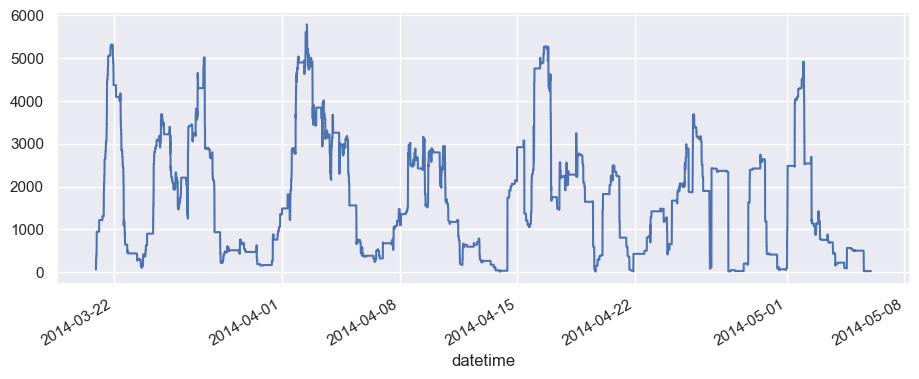

In [170]:
s = vdata.loc[:, ('AS14.01' , 'appCat.social')].rolling('D').sum()
s[s.notnull()].plot()

<Axes: xlabel='datetime'>

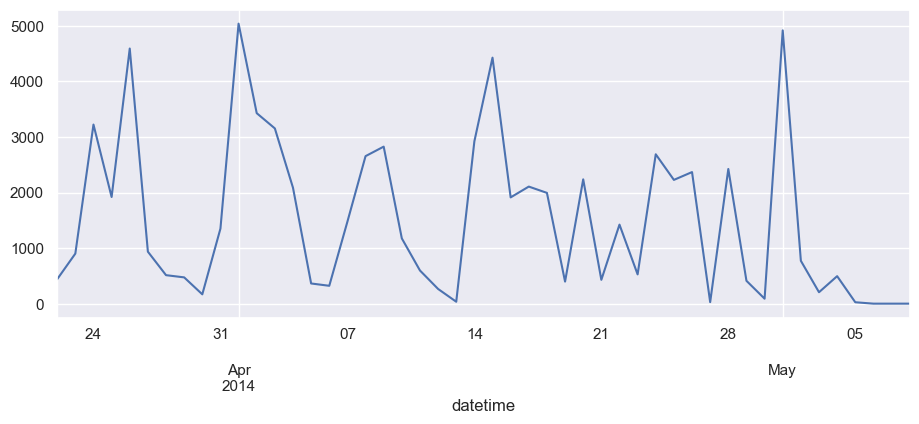

In [171]:
s = vdata.loc[:, ('AS14.01' , 'appCat.social')].resample('D').sum()
s.loc['2014-03-22':'2014-05-08'][s.notnull()].plot()

In [269]:
ids = list(samples["id"].unique())
d = {}
for id in ids:
    d[(id, "mood")] = vdata.loc[:, (id , 'mood')]
    d[(id, "valence")] = vdata.loc[:, (id , 'circumplex.valence')]
    d[(id, "arousal")] = vdata.loc[:, (id , 'circumplex.arousal')]
    d[(id, "mood_3H")] = vdata.loc[:, (id , 'mood')].resample('3H').mean()
    d[(id, "mood_1D")] = vdata.loc[:, (id , 'mood')].resample('D').mean()
    d[(id, "valence_1D")] = vdata.loc[:, (id , 'circumplex.valence')].resample('D').mean()
    d[(id, "arousal_1D")] = vdata.loc[:, (id , 'circumplex.arousal')].resample('D').mean()
    d[(id, "social_sum_1D")] = vdata.loc[:, (id , 'appCat.social')].resample('D').sum()
    d[(id, "social_rolling_5D")] = vdata.loc[:, (id , 'appCat.social')].rolling('5D').sum() / 5
    d[(id, "target")] = vdata.loc[:, (id , 'mood')].resample('D').mean().shift(-1)
features = pd.DataFrame(d)
features

AS14.01                                             \
                           mood valence arousal mood_3H mood_1D valence_1D   
datetime                                                                     
2014-02-17 00:00:00.000     NaN     NaN     NaN     NaN     NaN        NaN   
2014-02-17 06:00:00.000     NaN     NaN     NaN     NaN     NaN        NaN   
2014-02-17 07:00:52.197     NaN     NaN     NaN     NaN     NaN        NaN   
2014-02-17 07:12:13.631     NaN     NaN     NaN     NaN     NaN        NaN   
2014-02-17 07:49:19.635     NaN     NaN     NaN     NaN     NaN        NaN   
...                         ...     ...     ...     ...     ...        ...   
2014-06-08 12:00:00.000     NaN     NaN     NaN     NaN     NaN        NaN   
2014-06-08 15:00:00.000     NaN     NaN     NaN     NaN     NaN        NaN   
2014-06-08 18:00:00.000     NaN     NaN     NaN     NaN     NaN        NaN   
2014-06-08 21:00:00.000     NaN     NaN     NaN     NaN     NaN        NaN   
2014-06-09 00:00:00.000     NaN     NaN     NaN     NaN     NaN        NaN   

                                                                           \
                        arousal_1D social_sum_1D social_rolling_5D target   
datetime                                                                    
2014-02-17 00:00:00.000        NaN           0.0               NaN    NaN   
2014-02-17 06:00:00.000        NaN           NaN               NaN    NaN   
2014-02-17 07:00:52.197        NaN           NaN               NaN    NaN   
2014-02-17 07:12:13.631        NaN           NaN               NaN    NaN   
2014-02-17 07:49:19.635        NaN           NaN               NaN    NaN   
...                            ...           ...               ...    ...   
2014-06-08 12:00:00.000        NaN           NaN               NaN    NaN   
2014-06-08 15:00:00.000        NaN           NaN               NaN    NaN   
2014-06-08 18:00:00.000        NaN           NaN               NaN    NaN   
2014-06-08 21:00:00.000        NaN           NaN               NaN    NaN   
2014-06-09 00:00:00.000        NaN           0.0               NaN    NaN   

                         ... AS14.33                                  \
                         ...    mood valence arousal mood_3H mood_1D   
datetime                 ...                                           
2014-02-17 00:00:00.000  ...     NaN     NaN     NaN     NaN     NaN   
2014-02-17 06:00:00.000  ...     NaN     NaN     NaN     NaN     NaN   
2014-02-17 07:00:52.197  ...     NaN     NaN     NaN     NaN     NaN   
2014-02-17 07:12:13.631  ...     NaN     NaN     NaN     NaN     NaN   
2014-02-17 07:49:19.635  ...     NaN     NaN     NaN     NaN     NaN   
...                      ...     ...     ...     ...     ...     ...   
2014-06-08 12:00:00.000  ...     NaN     NaN     NaN     NaN     NaN   
2014-06-08 15:00:00.000  ...     NaN     NaN     NaN     NaN     NaN   
2014-06-08 18:00:00.000  ...     NaN     NaN     NaN     NaN     NaN   
2014-06-08 21:00:00.000  ...     NaN     NaN     NaN     NaN     NaN   
2014-06-09 00:00:00.000  ...     NaN     NaN     NaN     NaN     NaN   

                                                                               \
                        valence_1D arousal_1D social_sum_1D social_rolling_5D   
datetime                                                                        
2014-02-17 00:00:00.000        NaN        NaN           0.0               NaN   
2014-02-17 06:00:00.000        NaN        NaN           NaN               NaN   
2014-02-17 07:00:52.197        NaN        NaN           NaN               NaN   
2014-02-17 07:12:13.631        NaN        NaN           NaN               NaN   
2014-02-17 07:49:19.635        NaN        NaN           NaN               NaN   
...                            ...        ...           ...               ...   
2014-06-08 12:00:00.000        NaN        NaN           NaN               NaN   
2014-06-08 15:00:00.000        Na

In [270]:
features.columns

MultiIndex([('AS14.01',              'mood'),
            ('AS14.01',           'valence'),
            ('AS14.01',           'arousal'),
            ('AS14.01',           'mood_3H'),
            ('AS14.01',           'mood_1D'),
            ('AS14.01',        'valence_1D'),
            ('AS14.01',        'arousal_1D'),
            ('AS14.01',     'social_sum_1D'),
            ('AS14.01', 'social_rolling_5D'),
            ('AS14.01',            'target'),
            ...
            ('AS14.33',              'mood'),
            ('AS14.33',           'valence'),
            ('AS14.33',           'arousal'),
            ('AS14.33',           'mood_3H'),
            ('AS14.33',           'mood_1D'),
            ('AS14.33',        'valence_1D'),
            ('AS14.33',        'arousal_1D'),
            ('AS14.33',     'social_sum_1D'),
            ('AS14.33', 'social_rolling_5D'),
            ('AS14.33',            'target')],
           length=270)

In [271]:
features.index

DatetimeIndex([       '2014-02-17 00:00:00',        '2014-02-17 06:00:00',
               '2014-02-17 07:00:52.197000', '2014-02-17 07:12:13.631000',
               '2014-02-17 07:49:19.635000', '2014-02-17 08:57:16.313000',
               '2014-02-17 08:58:58.471000',        '2014-02-17 09:00:00',
               '2014-02-17 09:00:42.312000', '2014-02-17 09:01:34.747000',
               ...
                      '2014-06-08 11:00:00', '2014-06-08 11:03:34.453000',
               '2014-06-08 11:04:20.233000', '2014-06-08 11:04:36.299000',
               '2014-06-08 11:04:46.335000',        '2014-06-08 12:00:00',
                      '2014-06-08 15:00:00',        '2014-06-08 18:00:00',
                      '2014-06-08 21:00:00',        '2014-06-09 00:00:00'],
              dtype='datetime64[ns]', name='datetime', length=337076, freq=None)

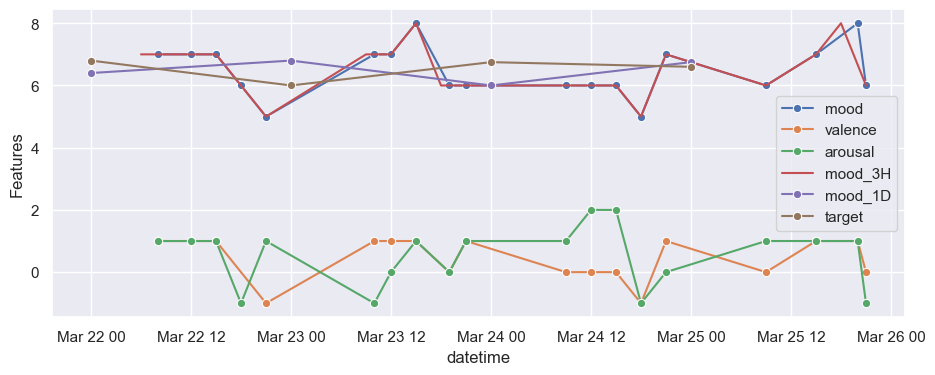

In [272]:
id = 'AS14.01'
start, end = '2014-03-22', '2014-03-25'
data = features[id]

fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d %H'))

sns.lineplot(data['mood'].loc[start:end], label='mood', marker='o')
sns.lineplot(data['valence'].loc[start:end], label='valence', marker='o')
sns.lineplot(data['arousal'].loc[start:end], label='arousal', marker='o')
sns.lineplot(data['mood_3H'].loc[start:end], label='mood_3H')
sns.lineplot(data['mood_1D'].loc[start:end], label='mood_1D', marker='o')
sns.lineplot(data['target'].loc[start:end], label='target', marker='o')
ax.set_ylabel('Features')
ax.legend();

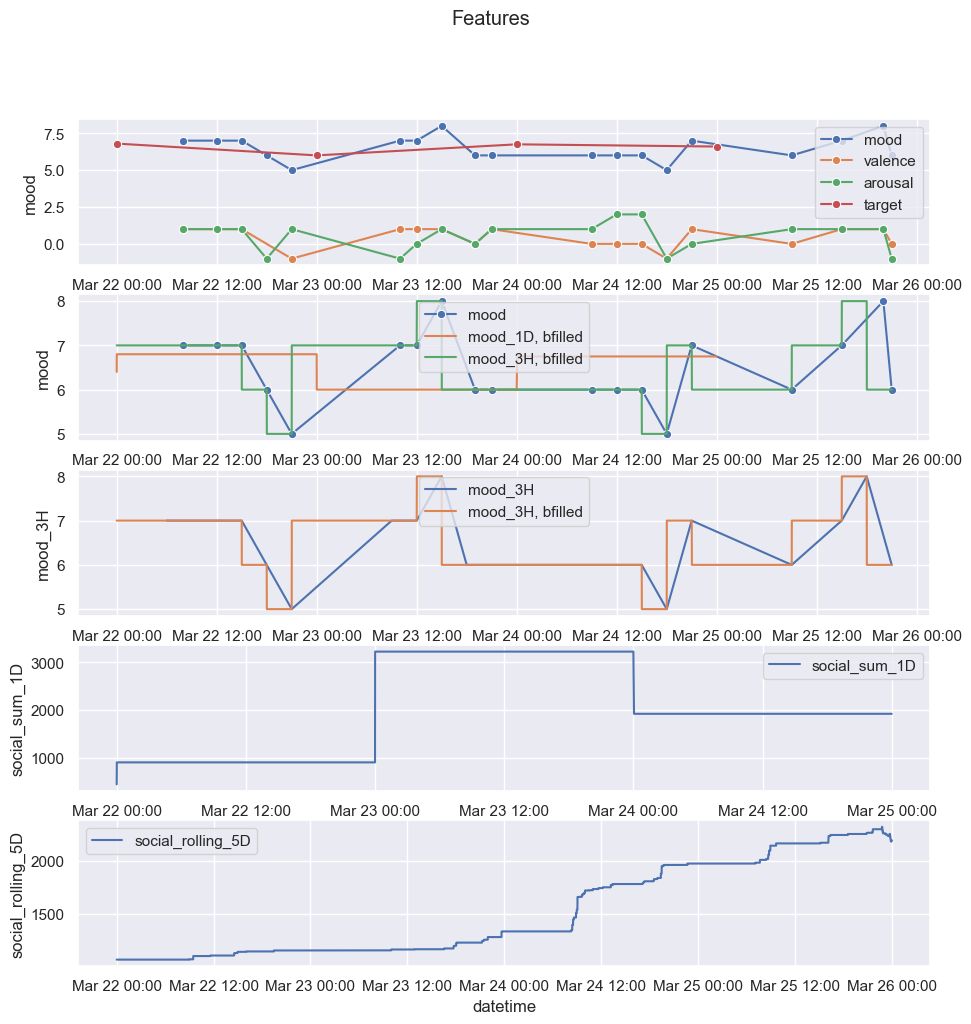

In [275]:
id = 'AS14.01'
start, end = '2014-03-22', '2014-03-25'
data = features[id]

fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(11, 11))
for ax in axs:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d %H:%M'))
fig.suptitle('Features')

sns.lineplot(ax=axs[0], data=data['mood'].loc[start:end], label='mood', marker='o')
sns.lineplot(ax=axs[0], data=data['valence'].loc[start:end], label='valence', marker='o')
sns.lineplot(ax=axs[0], data=data['arousal'].loc[start:end], label='arousal', marker='o')
sns.lineplot(ax=axs[0], data=data['target'].loc[start:end], label='target', marker='o')
axs[0].legend()

sns.lineplot(ax=axs[1], data=data['mood'].loc[start:end], label='mood', marker='o')
sns.lineplot(ax=axs[1], data=data['mood_1D'].loc[start:end].fillna(method='bfill'), label='mood_1D, bfilled')
sns.lineplot(ax=axs[1], data=data['mood_3H'].loc[start:end].fillna(method='bfill'), label='mood_3H, bfilled')
#sns.lineplot(ax=axs[1], data=data['mood_3H'].loc[start:end], label='mood_3H')

sns.lineplot(ax=axs[2], data=data['mood_3H'].loc[start:end], label='mood_3H')
sns.lineplot(ax=axs[2], data=data['mood_3H'].loc[start:end].fillna(method='bfill'), label='mood_3H, bfilled')

sns.lineplot(ax=axs[3], data=data['social_sum_1D'].loc[start:end].fillna(method='bfill'), label='social_sum_1D')

sns.lineplot(ax=axs[4], data=data['social_rolling_5D'].loc[start:end], label='social_rolling_5D');


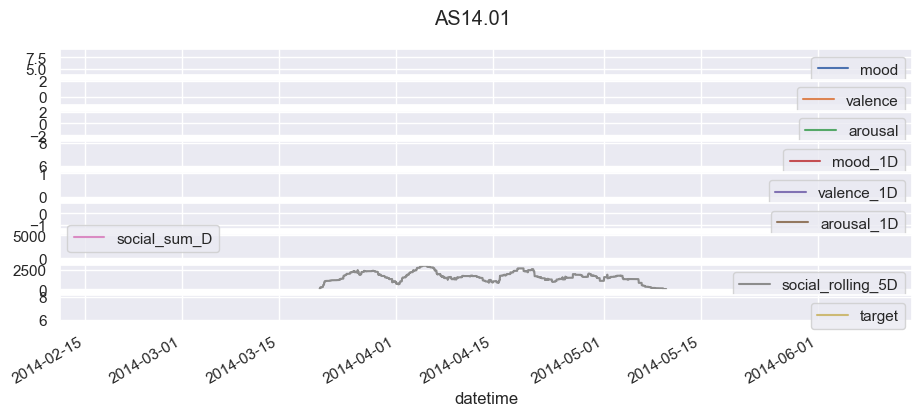

In [225]:
data.plot(subplots=True, title=id);

<Axes: xlabel='datetime', ylabel='social_rolling_5D'>

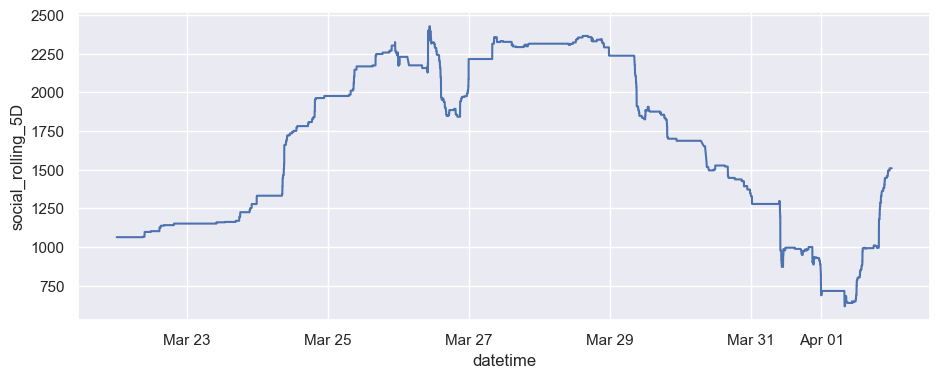

In [207]:
fig, ax = plt.subplots()
#ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

sns.lineplot(data.loc[start:end]['social_rolling_5D'])

<Axes: xlabel='datetime', ylabel='social_sum_1D'>

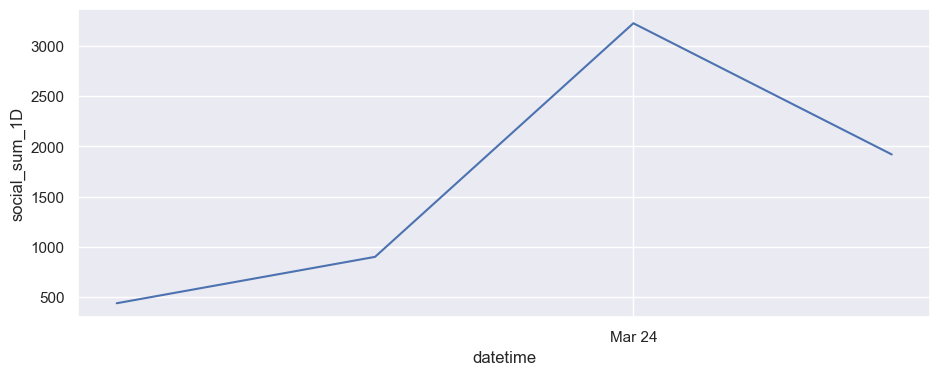

In [251]:
fig, ax = plt.subplots()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

sns.lineplot(data.loc[start:end]['social_sum_1D'])

In [217]:
data.loc[data['mood'].notnull()]

,mood,valence,arousal,mood_1D,valence_1D,arousal_1D,social_sum_D,social_rolling_5D,target
datetime,,,,,,,,,
2014-02-26 13:00:00,6.0,0.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-26 15:00:00,6.0,1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-26 18:00:00,6.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-26 21:00:00,7.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-27 09:00:00,6.0,0.0,-2.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2014-05-03 21:00:00,8.0,1.0,-1.0,NaN,NaN,NaN,NaN,1274.5760,NaN
2014-05-04 11:00:00,8.0,1.0,-1.0,NaN,NaN,NaN,NaN,1217.6720,NaN
2014-05-04 12:00:00,8.0,1.0,0.0,NaN,NaN,NaN,NaN,1217.6720,NaN


In [188]:
data.loc[data['social_rolling_5D'].notnull()]

,valence,arousal,social_sum_D,social_rolling_5D,mood,target
datetime,,,,,,
2014-03-20 22:49:38.631,NaN,NaN,NaN,12.3282,NaN,NaN
2014-03-20 22:49:47.946,NaN,NaN,NaN,12.3282,NaN,NaN
2014-03-20 22:50:04.135,NaN,NaN,NaN,12.3282,NaN,NaN
2014-03-20 22:50:28.256,NaN,NaN,NaN,12.3282,NaN,NaN
2014-03-20 22:50:34.809,NaN,NaN,NaN,12.3282,NaN,NaN
...,...,...,...,...,...,...
2014-05-10 00:32:10.719,NaN,NaN,NaN,5.0208,NaN,NaN
2014-05-10 00:32:40.911,NaN,NaN,NaN,5.0208,NaN,NaN
2014-05-10 00:33:40.055,NaN,NaN,NaN,5.0208,NaN,NaN
